This file will be used to add a indicator to each sample {-1: left extreme event, 0: normal event, 1:right extreme event}

In [10]:
import numpy as np
dataset = "NYCTaxi"
data_path = fr"D:\omer\ST-SSL\data\{dataset}\train.npz"
x_train = np.load(data_path)["x"]
y_train = np.load(data_path)["y"]

In [11]:
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (1912, 35, 200, 2), y_train shape: (1912, 1, 200, 2)


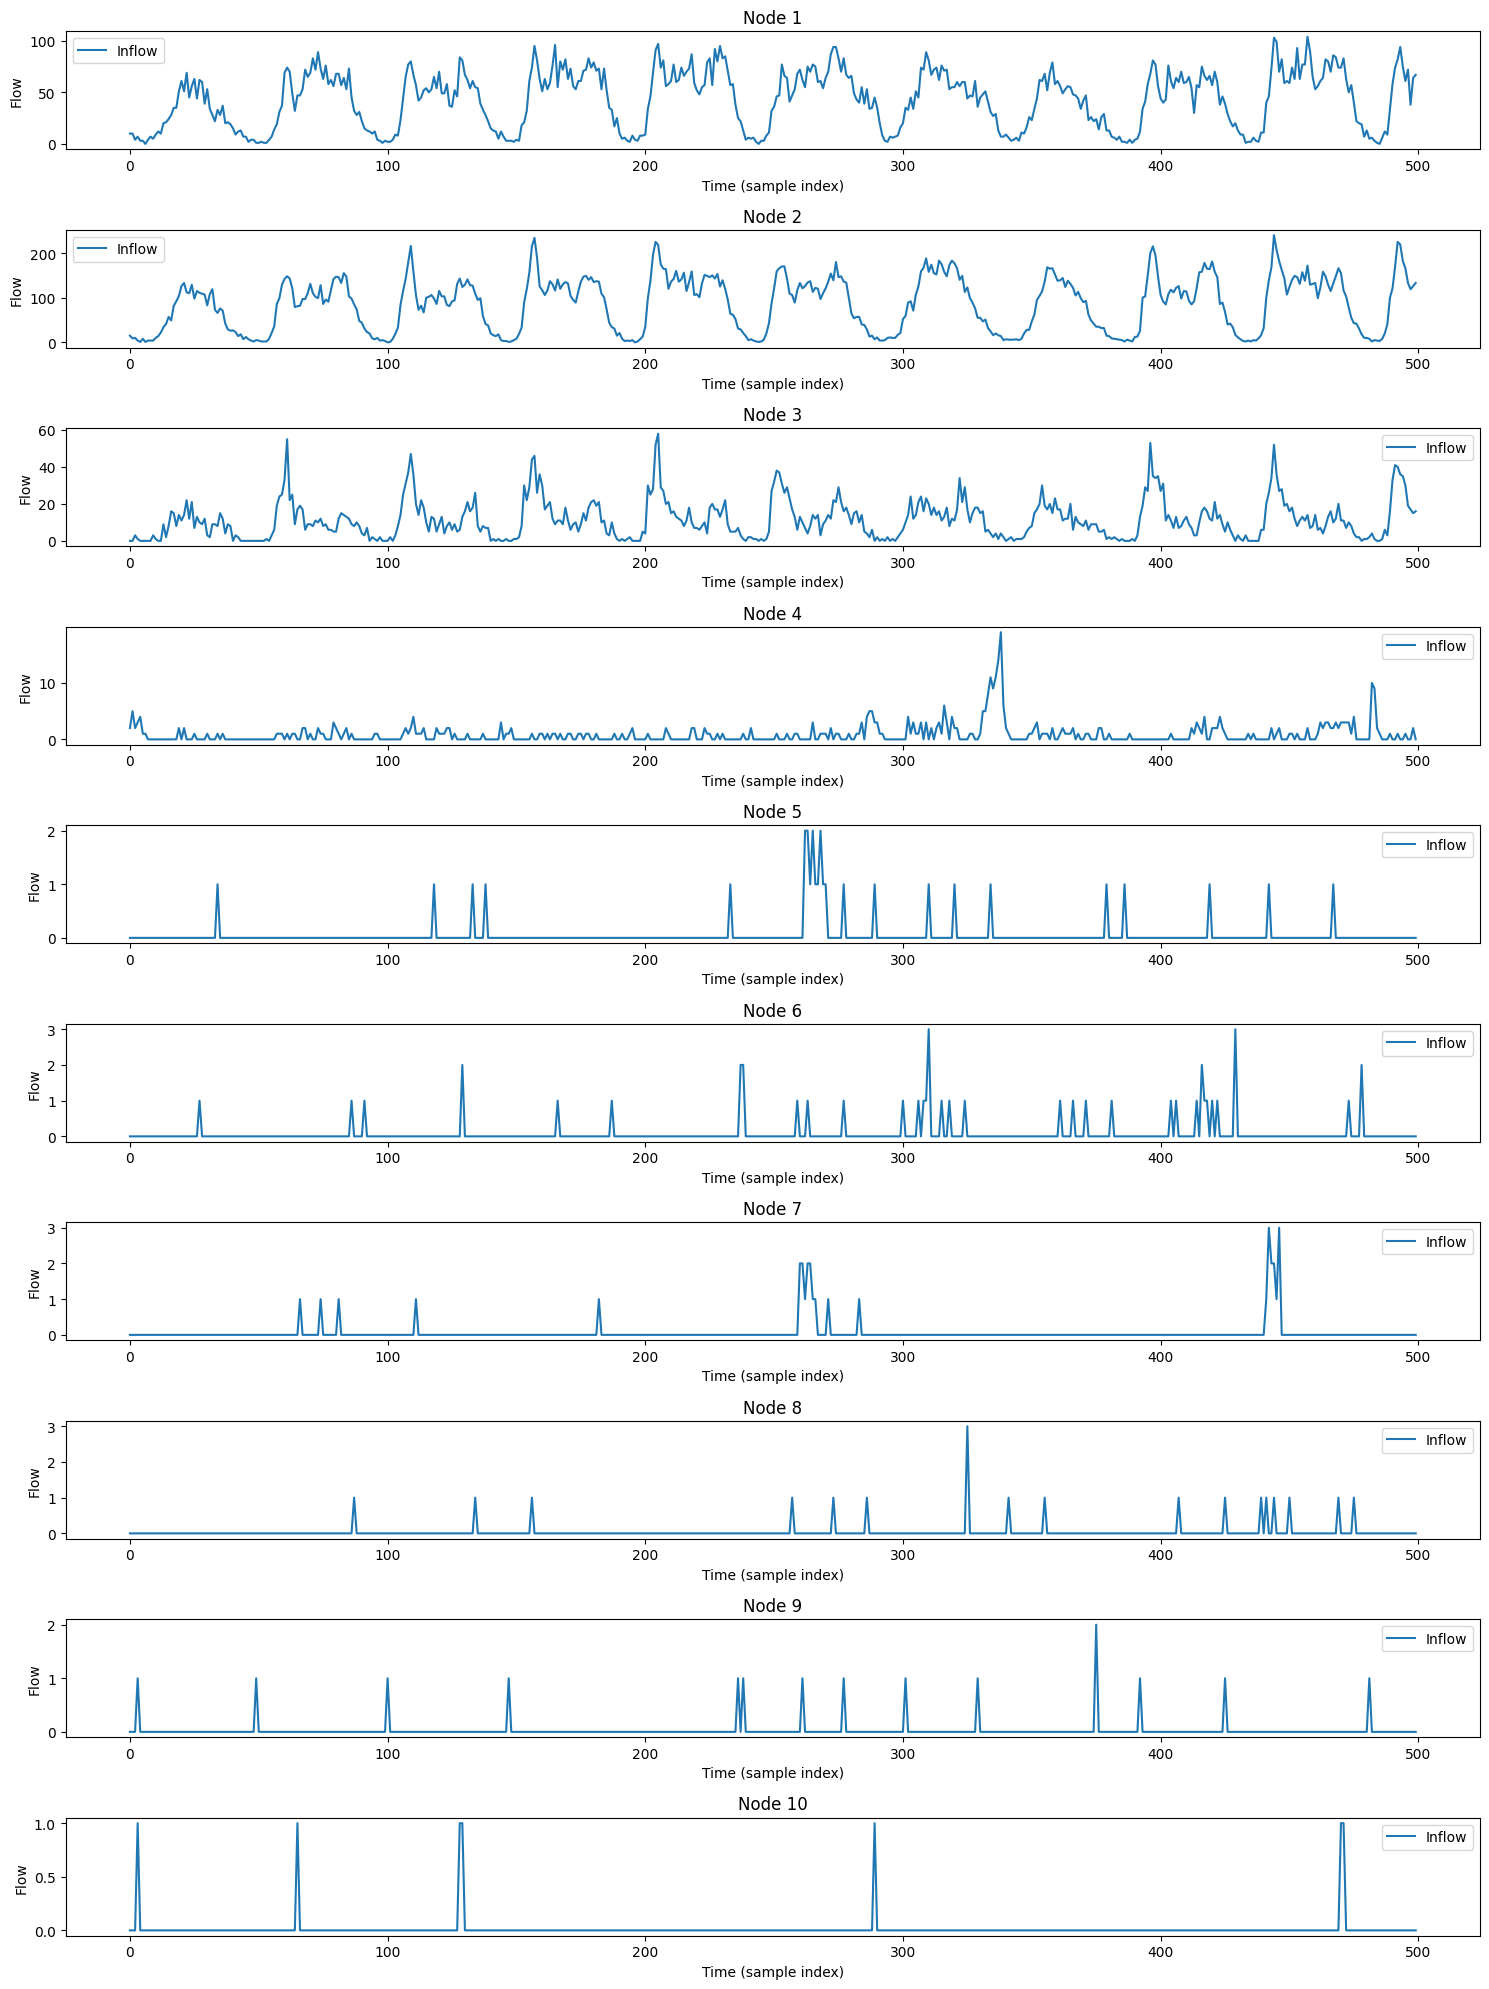

In [12]:
# y_train shape: (1912, 1, 200, 2)
## plot the timeseries at each node
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 20))
for node_index in range(10):
    inflow = y_train[0:500, 0, node_index, 0]
    # outflow = y_train[:, 0, node_index, 1]

    plt.subplot(10, 1, node_index + 1)
    plt.plot(inflow, label='Inflow')
    # plt.plot(outflow, label='Outflow')
    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()

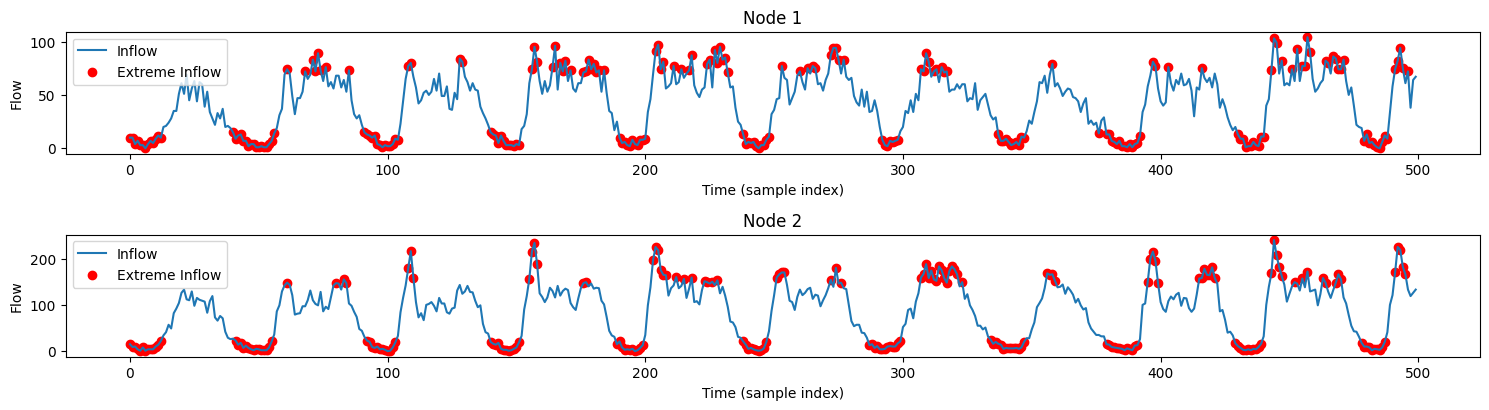

In [5]:
import numpy as np
import matplotlib.pyplot as plt

## std dev away from mean

# Set up the plot
plt.figure(figsize=(15, 20))

# Z-score threshold for extreme events
z_threshold = 1

# Plotting the first 10 nodes
for node_index in range(2):
    inflow = y_train[0:500, 0, node_index, 0]
    # outflow = y_train[:, 0, node_index, 1]

    # Compute means and standard deviations
    mean_inflow = np.mean(inflow)
    std_inflow = np.std(inflow)
    # mean_outflow = np.mean(outflow)
    # std_outflow = np.std(outflow)

    # Identify extreme events
    extreme_inflow = np.where(np.abs((inflow - mean_inflow) / std_inflow) > z_threshold)[0]
    # extreme_outflow = np.where(np.abs((outflow - mean_outflow) / std_outflow) > z_threshold)[0]

    plt.subplot(10, 1, node_index + 1)
    plt.plot(inflow, label='Inflow')
    # plt.plot(outflow, label='Outflow')
    plt.scatter(extreme_inflow, inflow[extreme_inflow], color='red', label='Extreme Inflow', marker='o')
    # plt.scatter(extreme_outflow, outflow[extreme_outflow], color='blue', label='Extreme Outflow', marker='x')
    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()


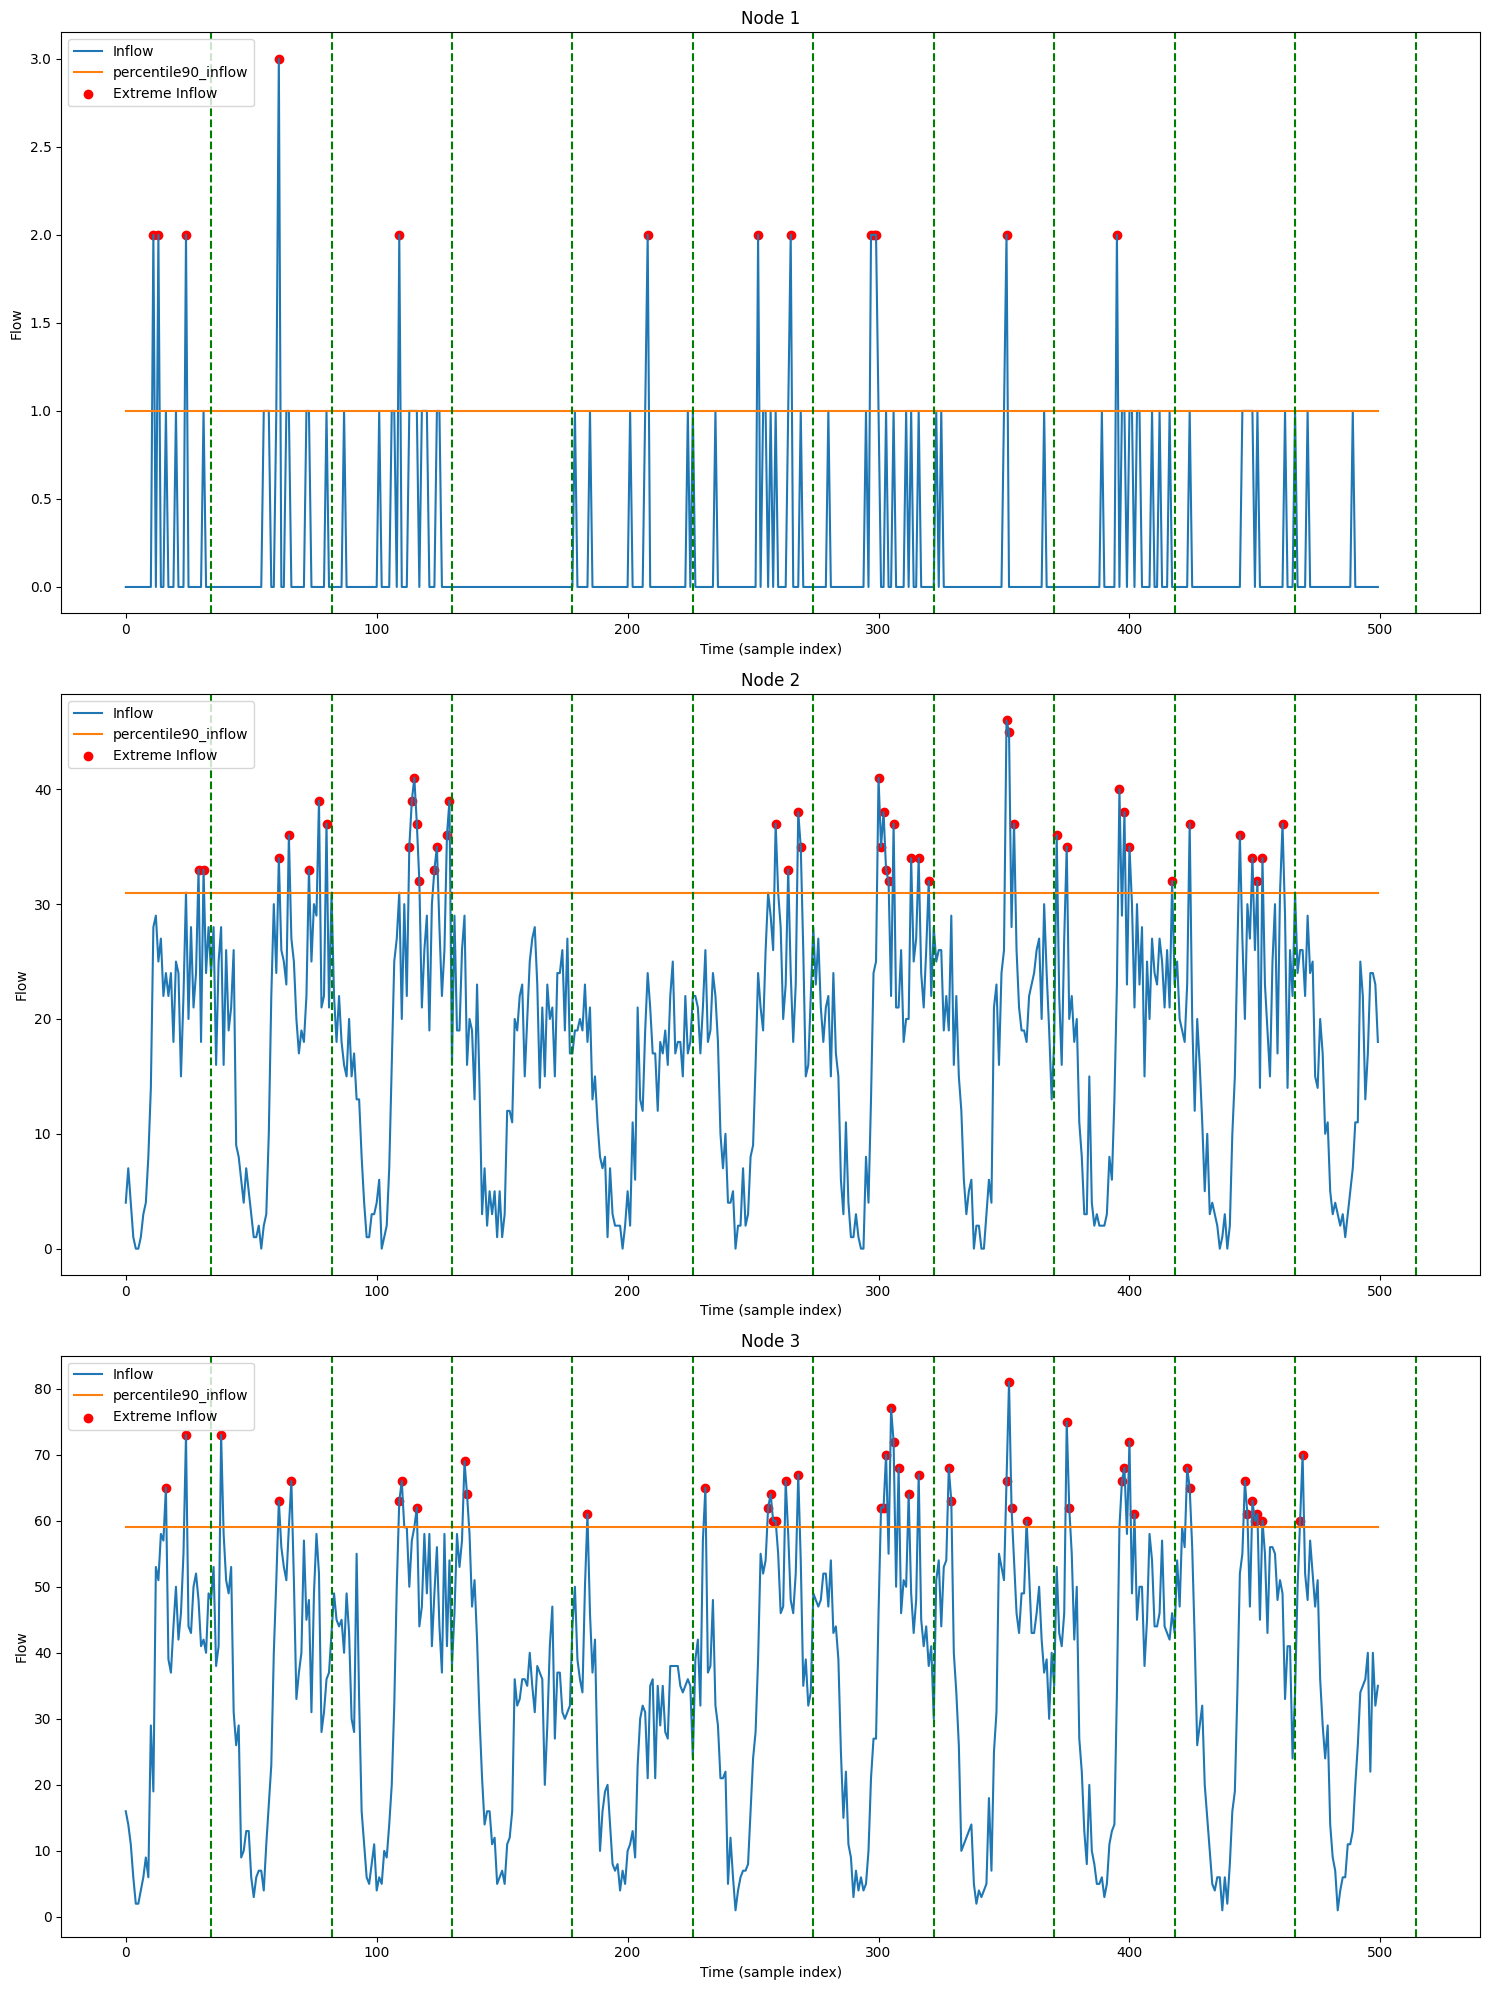

In [7]:
import numpy as np
import matplotlib.pyplot as plt

## outside of xxth percentile
xx = 90
# Set up the plot
plt.figure(figsize=(15, 20))

# Plotting the first 10 nodes
for node_index in range(3):
    s, e = 0, 500
    inflow = y_train[s:e, 0, node_index, 0]
    outflow = y_train[s:e, 0, node_index, 1]

    # Calculate the 90th percentile for inflow and outflow
    percentile90_inflow = np.percentile(inflow, xx)
    percentile90_outflow = np.percentile(outflow, xx)

    # Identify indices where data exceeds the 90th percentile
    extreme_inflow_indices = np.where(inflow > percentile90_inflow)[0]
    extreme_outflow_indices = np.where(outflow > percentile90_outflow)[0]

    plt.subplot(3, 1, node_index + 1)
    plt.plot(inflow, label='Inflow')
    # repeat percentile90_inflow to match the length of inflow
    percentile90_inflow = np.repeat(percentile90_inflow, len(inflow))
    percentile90_outflow = np.repeat(percentile90_outflow, len(outflow))
    plt.plot(percentile90_inflow, label='percentile90_inflow')
    # plt.plot(percentile90_outflow, label='percentile90_outflow')

    b = 34
    for i in range(s+b, e+b, 48):
        plt.axvline(x=i-s, color='green', linestyle='--')
    # plt.plot(outflow, label='Outflow')
    plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow', marker='o')
    # plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')
    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()


In [26]:
## create a binary tensor with indicators for extreme events

import numpy as np

# Assume y_train is already defined
# Initialize binary tensor

# Define the percentile
xx = 90

dataset = "NYCTaxi"
for split in ["train", "val", "test"]:
    data_path = fr"D:\omer\ST-SSL\data\{dataset}\{split}.npz"
    x_train = np.load(data_path)["x"]
    y_train = np.load(data_path)["y"]
    extreme_values_binary_tensor = np.zeros_like(y_train)

    # Loop through each node and each direction (inflow, outflow)
    for node_index in range(y_train.shape[2]):  # Assuming y_train shape is [samples, timesteps, nodes, directions]
        for direction_index in range(y_train.shape[3]):
            # Get the data for current node and direction
            data = y_train[:, 0, node_index, direction_index]

            # Calculate the xxth percentile
            threshold = np.percentile(data, xx)

            # Find indices where data exceeds the threshold
            extreme_indices = np.where(data > threshold)[0]

            # Update the binary tensor
            extreme_values_binary_tensor[extreme_indices, 0, node_index, direction_index] = 1
    np.savez(data_path, x=x_train, y=y_train, evs_90=extreme_values_binary_tensor)
    # extreme_values_binary_tensor now contains 1s at the indices of extreme values


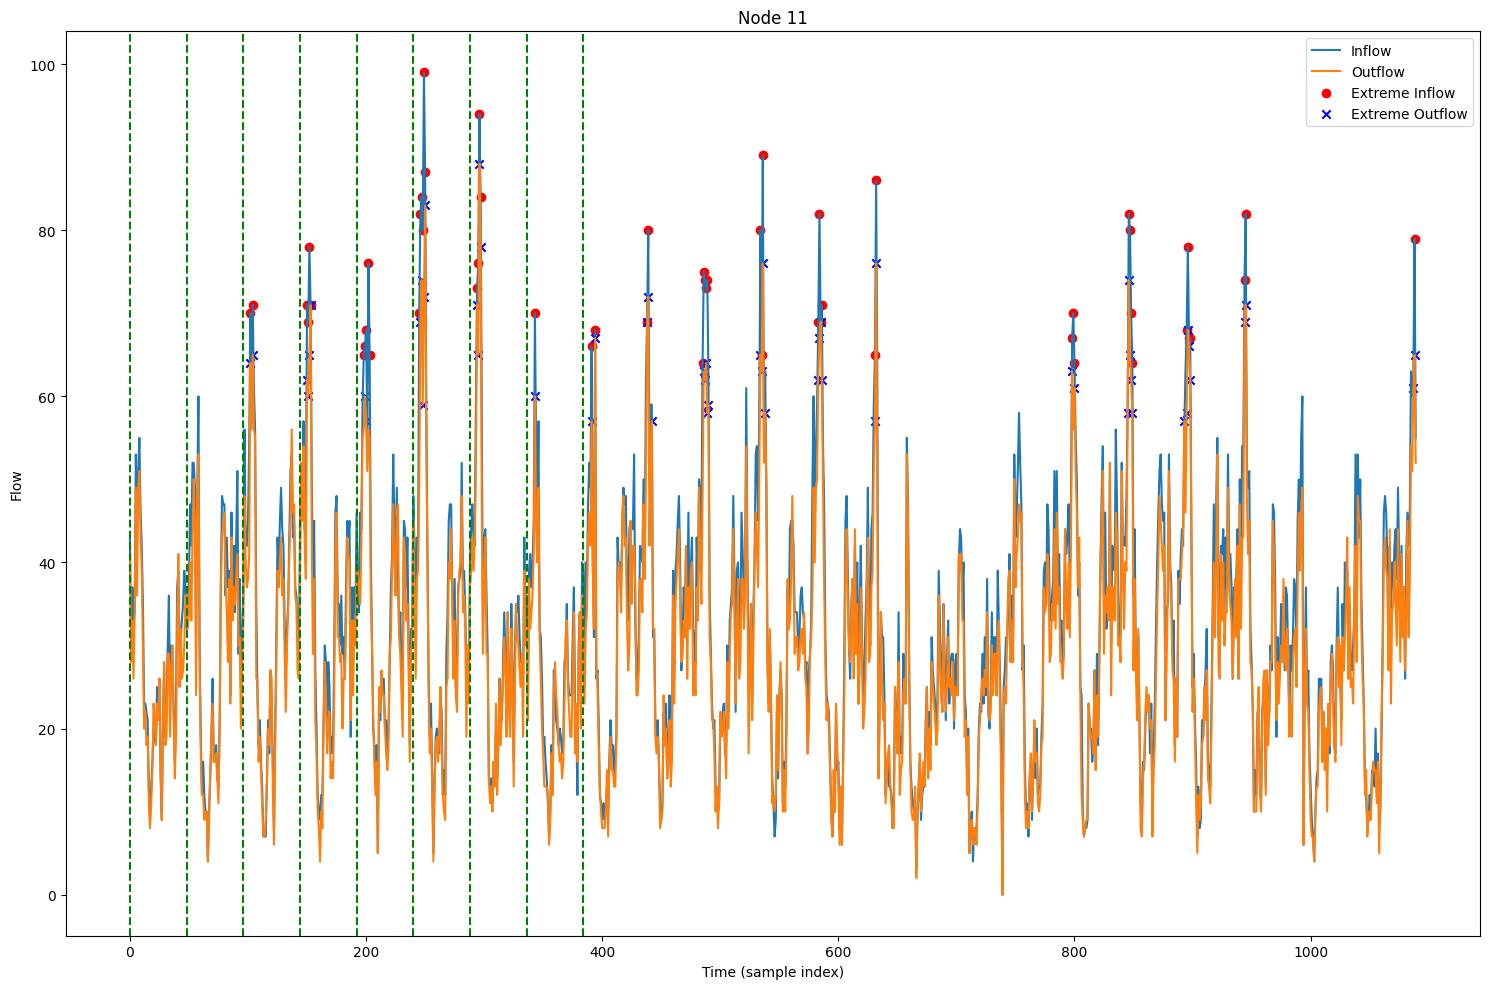

In [22]:
## plot from the newly defined binary tensor

import numpy as np
import matplotlib.pyplot as plt

# Assuming y_train and extreme_indicator_tensor are defined with the same shape
# and extreme_indicator_tensor contains 1 where there's an extreme event and 0 otherwise

# Set up the plot
plt.figure(figsize=(15, 10))

# Plotting for the first node (as the loop range is 1, it plots only the first node)
for node_index in range(1):
    r=10
    node_index += r
    inflow = y_train[:, 0, node_index, 0]
    outflow = y_train[:, 0, node_index, 1]
    
    # Extract extreme indicators for inflow and outflow
    extreme_inflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 0]
    extreme_outflow_indicator = extreme_values_binary_tensor[:, 0, node_index, 1]
    
    # Identify indices where extreme events occur
    extreme_inflow_indices = np.where(extreme_inflow_indicator == 1)[0]
    extreme_outflow_indices = np.where(extreme_outflow_indicator == 1)[0]

    # Plotting inflow and outflow
    plt.subplot(1, 1, node_index - r + 1)
    plt.plot(inflow, label='Inflow')
    plt.plot(outflow, label='Outflow')

    # Marking the extreme events
    plt.scatter(extreme_inflow_indices, inflow[extreme_inflow_indices], color='red', label='Extreme Inflow', marker='o')
    plt.scatter(extreme_outflow_indices, outflow[extreme_outflow_indices], color='blue', label='Extreme Outflow', marker='x')

    for i in range(s, e, 48):
        plt.axvline(x=i-s, color='green', linestyle='--')
        
    plt.title(f'Node {node_index + 1}')
    plt.xlabel('Time (sample index)')
    plt.ylabel('Flow')
    plt.legend()

plt.tight_layout()
plt.show()


In [27]:
## save the extreme_values_binary_tensor
# import numpy as np
# np.savez(r"D:\omer\onlineJEPATrain\data\NYCTaxi\extreme_values_binary_tensor.npz", extreme_values_binary_tensor=extreme_values_binary_tensor)

Make noisy dataset

In [1]:
import numpy as np
dataset = "NYCTaxi"
data_path = fr"D:\omer\ST-SSL\data\{dataset}\test.npz"
x_train = np.load(data_path)["x"]
y_train = np.load(data_path)["y"]
extreme_values_binary_tensor = np.load(data_path)["evs"]
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, evs.shape: {extreme_values_binary_tensor.shape}")

x_train shape: (546, 35, 200, 2), y_train shape: (546, 1, 200, 2), evs.shape: (546, 1, 200, 2)


In [2]:
def add_noise(tensor, perc_ones_to_flip, perc_zeros_to_flip):
    B, T, N, D = tensor.shape
    flat_array = tensor.flatten()

    # Find indices of all 1s and 0s
    ones_indices = np.where(flat_array == 1)[0]
    zeros_indices = np.where(flat_array == 0)[0]

    # Calculate the number of 1s and 0s to flip based on the percentages
    n = int(len(ones_indices) * perc_ones_to_flip / 100)
    m = int(len(zeros_indices) * perc_zeros_to_flip / 100)

    # Randomly choose n 1s and m 0s to flip
    indices_to_flip_ones = np.random.choice(ones_indices, n, replace=False)
    indices_to_flip_zeros = np.random.choice(zeros_indices, m, replace=False)

    # Flip the chosen 1s to 0s and 0s to 1s
    flat_array[indices_to_flip_ones] = 0
    flat_array[indices_to_flip_zeros] = 1

    # Reshape the array back to its original shape
    noisy_tensor = flat_array.reshape(B, T, N, D)
    return noisy_tensor

x_train shape: (1912, 35, 200, 2), y_train shape: (1912, 1, 200, 2), evs.shape: (1912, 1, 200, 2)


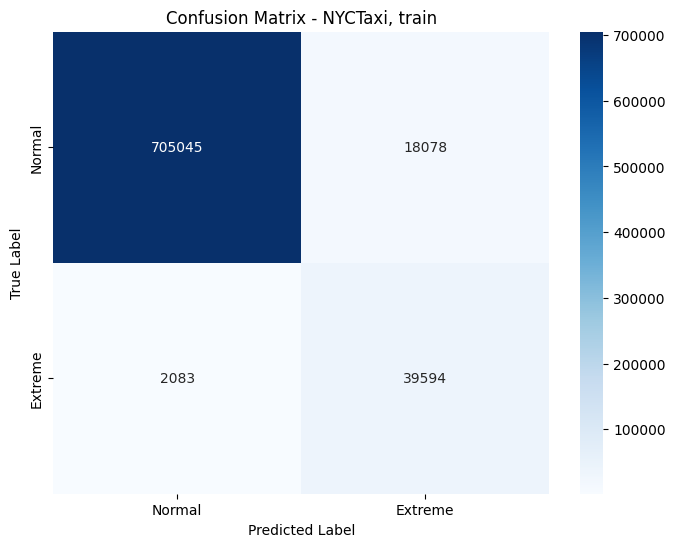

x_train shape: (274, 35, 200, 2), y_train shape: (274, 1, 200, 2), evs.shape: (274, 1, 200, 2)


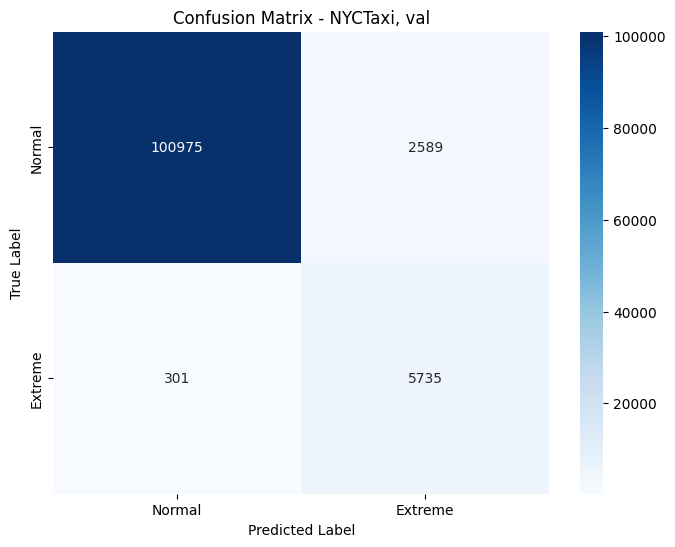

x_train shape: (546, 35, 200, 2), y_train shape: (546, 1, 200, 2), evs.shape: (546, 1, 200, 2)


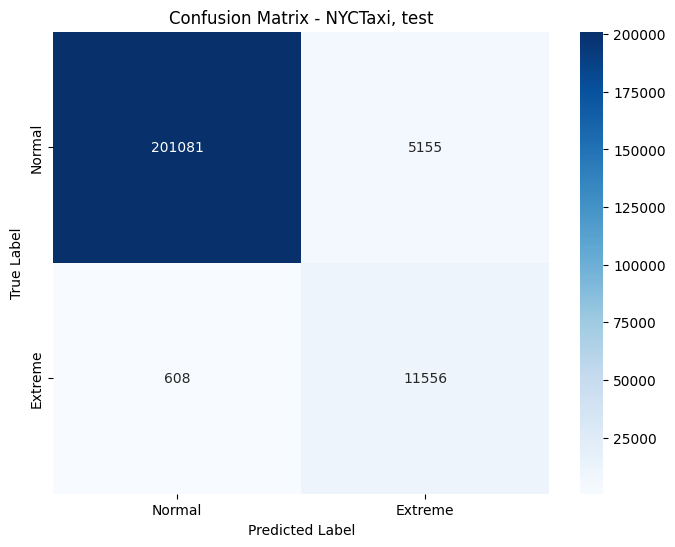

x_train shape: (3023, 19, 128, 2), y_train shape: (3023, 1, 128, 2), evs.shape: (3023, 1, 128, 2)


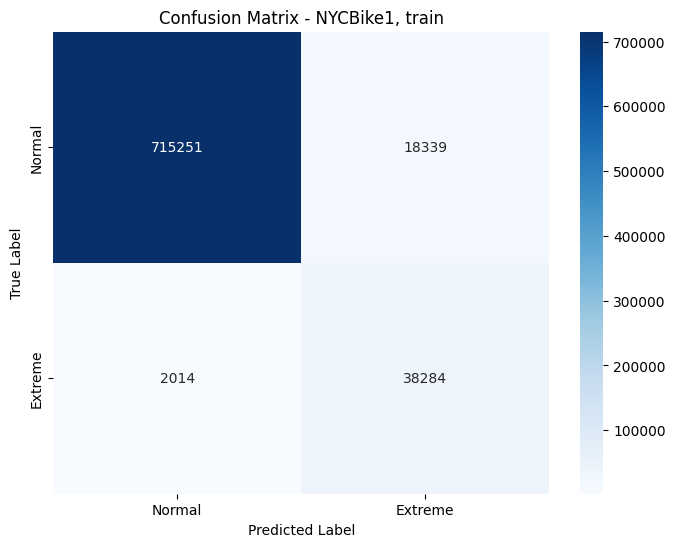

x_train shape: (431, 19, 128, 2), y_train shape: (431, 1, 128, 2), evs.shape: (431, 1, 128, 2)


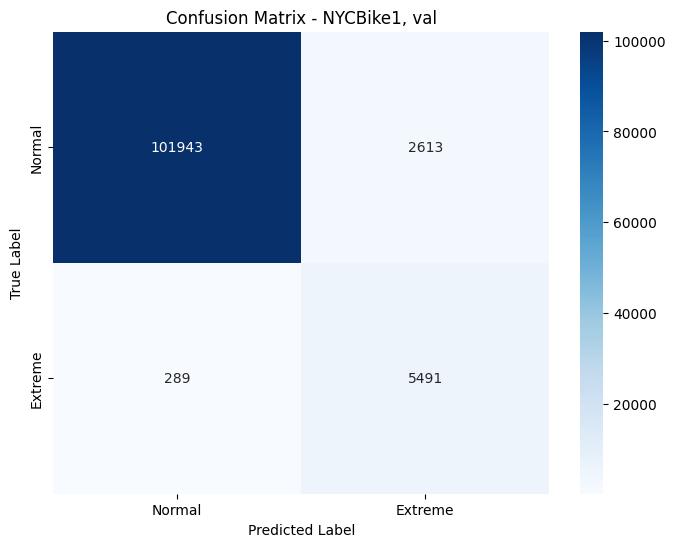

x_train shape: (864, 19, 128, 2), y_train shape: (864, 1, 128, 2), evs.shape: (864, 1, 128, 2)


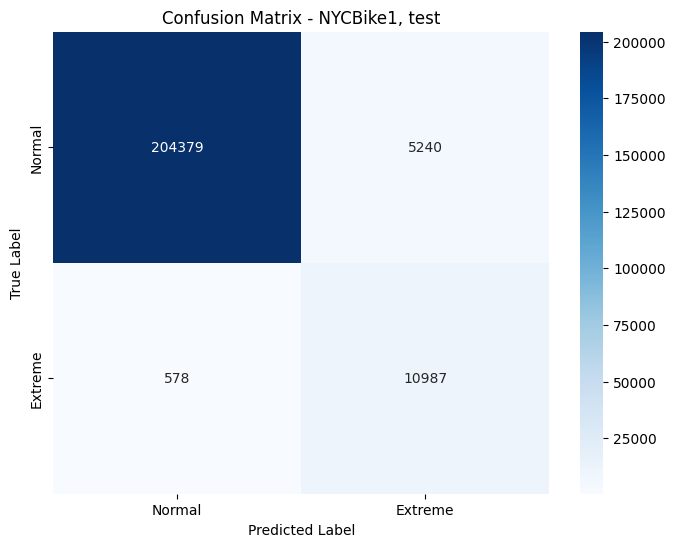

x_train shape: (1912, 35, 200, 2), y_train shape: (1912, 1, 200, 2), evs.shape: (1912, 1, 200, 2)


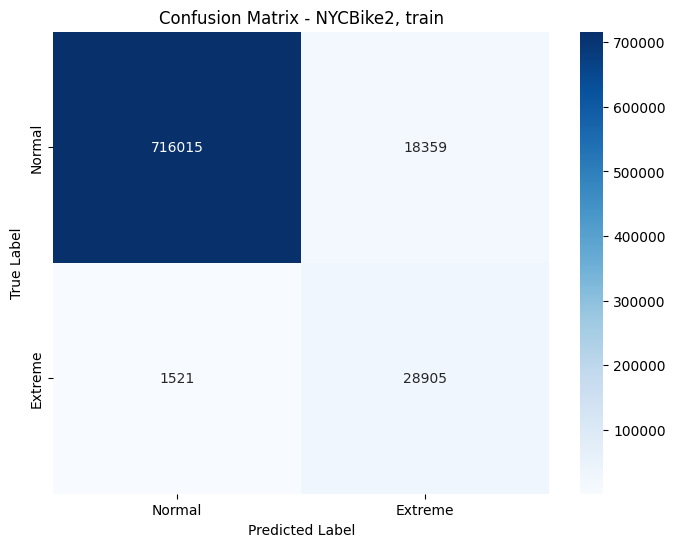

x_train shape: (274, 35, 200, 2), y_train shape: (274, 1, 200, 2), evs.shape: (274, 1, 200, 2)


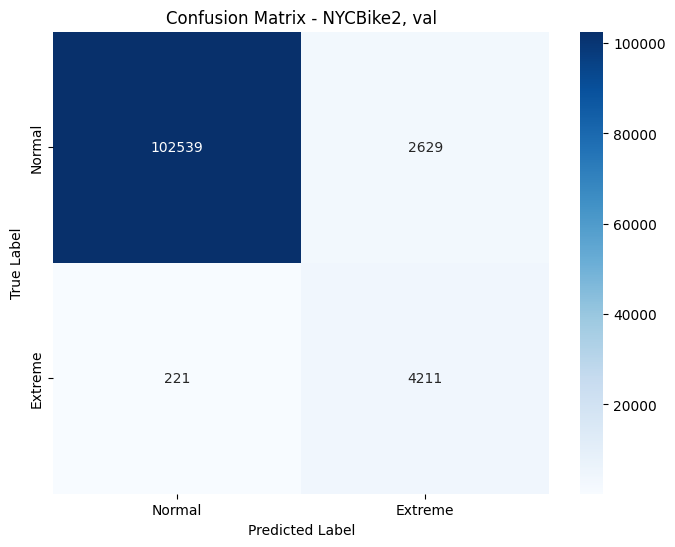

x_train shape: (546, 35, 200, 2), y_train shape: (546, 1, 200, 2), evs.shape: (546, 1, 200, 2)


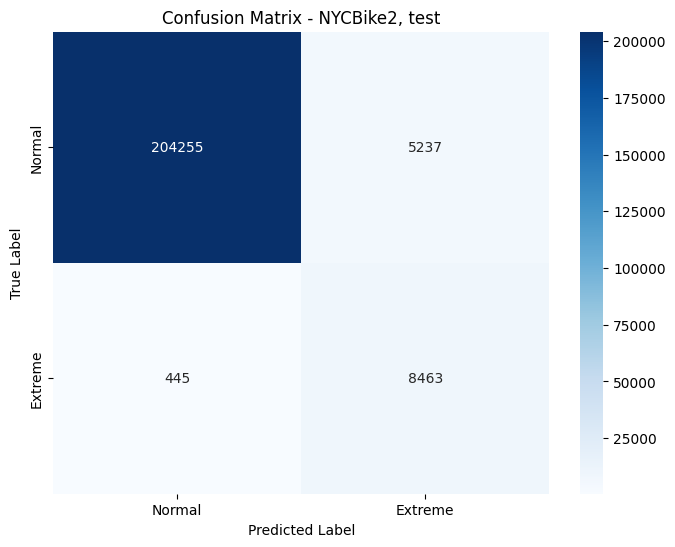

In [8]:
## confusion matrix with noisy data

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, balanced_accuracy_score
perc_ones_to_flip, perc_zeros_to_flip = 5, 2.5

datasets = ["NYCTaxi", "NYCBike1", "NYCBike2"]
for dataset in datasets:
    for split in ["train", "val", "test"]:
        data_path = fr"D:\omer\ST-SSL\data\{dataset}\{split}.npz"
        x_train = np.load(data_path)["x"]
        y_train = np.load(data_path)["y"]
        extreme_values_binary_tensor = np.load(data_path)["evs_noisy"]
        print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, evs.shape: {extreme_values_binary_tensor.shape}")
        extreme_values_binary_tensor_noisy = add_noise(extreme_values_binary_tensor, perc_ones_to_flip, perc_zeros_to_flip)
        # Example data, replace these with your actual data
        evs_pred_binary = (extreme_values_binary_tensor_noisy >= 0.5).astype(int)       # Threshold predictions at 0.2

        # Flatten the arrays
        evs_true_flat = extreme_values_binary_tensor.flatten()
        evs_pred_flat = evs_pred_binary.flatten()

        # Calculate confusion matrix
        conf_matrix = confusion_matrix(evs_true_flat, evs_pred_flat)

        # Plotting the confusion matrix using seaborn
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
                    xticklabels=["Normal", "Extreme"], yticklabels=["Normal", "Extreme"])
        plt.title(f"Confusion Matrix - {dataset}, {split}")
        plt.ylabel("True Label")
        plt.xlabel("Predicted Label")
        plt.show()


In [9]:
## create a binary tensor with indicators for extreme events

import numpy as np

# Assume y_train is already defined
# Initialize binary tensor

# Define the percentile
xx = 95
perc_ones_to_flip, perc_zeros_to_flip = 2, 1
datasets = ["NYCTaxi", "NYCBike1", "NYCBike2"]
for dataset in datasets:
    for split in ["train", "val", "test"]:
        print(f"split: {split}")
        data_path = fr"D:\omer\ST-SSL\data\{dataset}\{split}.npz"
        x_train = np.load(data_path)["x"]
        y_train = np.load(data_path)["y"]
        extreme_values_binary_tensor = np.load(data_path)["evs"]
        extreme_values_binary_tensor_noisy = add_noise(extreme_values_binary_tensor, perc_ones_to_flip, perc_zeros_to_flip)
        # np.savez(data_path, x=x_train, y=y_train, evs=extreme_values_binary_tensor, evs_noisy=extreme_values_binary_tensor_noisy)
        print("done")
        # extreme_values_binary_tensor now contains 1s at the indices of extreme values
    print("done")
print("done")

split: train
done
split: val
done
split: test
done
done
split: train
done
split: val
done
split: test
done
done
split: train
done
split: val
done
split: test
done
done
done


In [12]:
## plot the created data

import numpy as np
dataset = "NYCBike1"
data_path = fr"D:\omer\ST-SSL\data\{dataset}\train.npz"
x_train = np.load(data_path)["x"]
y_train = np.load(data_path)["y"]
evs = np.load(data_path)["evs"]
print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}, evs.shape: {extreme_values_binary_tensor.shape}")
## x_train shape: (3023, 19, 128, 2), y_train shape: (3023, 1, 128, 2), evs.shape: (3023, 1, 128, 2)

x_train shape: (3023, 19, 128, 2), y_train shape: (3023, 1, 128, 2), evs.shape: (3023, 1, 128, 2)


extreme_values_binary_tensor_noisy.shape: (3023, 1, 128, 2)


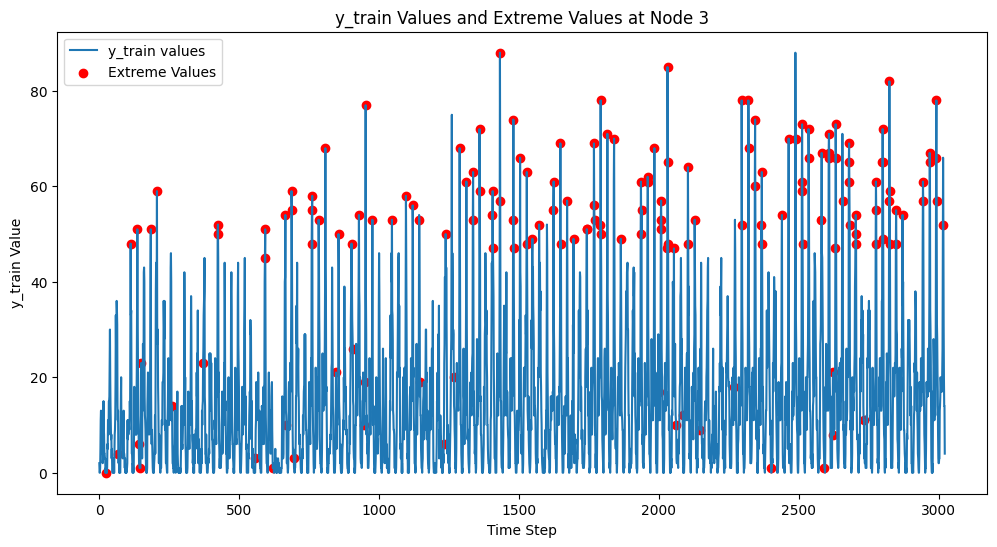

In [36]:
# Choose the node index (modify this as needed)
node_index = 3

# Extracting data for the selected node across all samples and both inflow/outflow
y_values = y_train[:, :, node_index, 0]
print(f"extreme_values_binary_tensor_noisy.shape: {extreme_values_binary_tensor_noisy.shape}")
evs_binary = extreme_values_binary_tensor_noisy[:, :, node_index, 0]

# Flatten the arrays to make plotting easier
y_values = y_values.flatten()
evs_binary = evs_binary.flatten()
# Create a time array corresponding to the data points
time_steps = np.arange(len(y_values))

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(time_steps, y_values, label='y_train values')
plt.scatter(time_steps[evs_binary == 1], y_values[evs_binary == 1], color='red', label='Extreme Values')
plt.title(f"y_train Values and Extreme Values at Node {node_index}")
plt.xlabel("Time Step")
plt.ylabel("y_train Value")
plt.legend()
plt.show()